In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imutils
import tensorflow as tf
from tensorflow import keras
from typing import Optional, List
from tqdm import tqdm
import matplotlib.pyplot as plt

In [8]:
from DataClasses import Exercise, FrameData, VideoData, Dataset, build_tf_dataset
from Models import ClassifierModel, normalize_label
# from pose_detection import extract_pose_from_video_interpolated

In [9]:
num_classes = 4
# num_classes = 22

clf = ClassifierModel(n_classes=num_classes)
model = clf.build_model()
# model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 33, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 33, 32)    │        128 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 32)    │        128 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 33, 32)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 33, 64)    │      2,112 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 64)    │        256 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 33, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 33, 512)   │     33,280 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 512)   │      2,048 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 33, 512)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_19[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     32,896 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 9)         │      1,161 │ activation_21[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 3, 3)      │          0 │ dense_11[0][0]  

 Total params: 748,205 (2.85 MB)

 Trainable params: 742,125 (2.83 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [10]:
# Pour créer le dataset simple si besoin

dataset_raw = pd.read_csv("data/full_landmarks_dataset.csv")

dataset_simple = dataset_raw[dataset_raw['label'].isin([
    'bench press', 
    'pull up', 
    'push up',
    'squat'
])]

dataset_simple.to_csv("data/simple_landmarks_dataset.csv", index=False)

In [11]:
# Conversion en dataset de frames


dataset = Dataset()

# dataset_raw = pd.read_csv("data/full_landmarks_dataset.csv")  # Pour charger le dataset complet
dataset_raw = pd.read_csv("data/simple_landmarks_dataset.csv")

# Ajout d'une barre de chargement avec tqdm
for index, data in tqdm(dataset_raw.iterrows(), total=len(dataset_raw), desc="Chargement du dataset"):
    frame_data = FrameData(
        filename=data["video_name"], 
        frame_index=data["frame_number"],
        landmarks=np.array(data.drop(["video_name","total_frames","frame_number","width","height","label"])).reshape(-1, 3),
        predicted_class=None,
        confidence=None,
        scores=None,
        ground_truth=Exercise(normalize_label(data["label"]))
    )
    dataset.add_data(frame_data)

print(f"Dataset chargé avec succès ! Total: {len(dataset.datas)} frames")

Chargement du dataset: 100%|██████████| 22706/22706 [00:08<00:00, 2620.71it/s]

Dataset chargé avec succès ! Total: 22706 frames


In [ ]:
# Split train / test
print("📊 Division du dataset...")
train_dataset, test_dataset = dataset.split(train_ratio=0.8)

# Vérification des classes dans chaque split
train_X, train_y = train_dataset.get_data_arrays()
test_X, test_y = test_dataset.get_data_arrays()

print(f"Classes d'entraînement uniques: {np.unique(train_y)}")
print(f"Classes de test uniques: {np.unique(test_y)}")

# === 3️⃣ Construction des datasets TensorFlow ===
print("🔧 Construction des datasets TensorFlow...")
train_tf_dataset = build_tf_dataset(train_dataset, num_classes=num_classes, batch_size=32)
test_tf_dataset = build_tf_dataset(test_dataset, num_classes=num_classes, batch_size=32)

# Vérification des formes
for batch in train_tf_dataset.take(1):
    X_batch, y_batch = batch
    print(f"Forme des batches d'entraînement: X={X_batch.shape}, y={y_batch.shape}")


# === 4️⃣ Entraînement ===
print("🎯 Début de l'entraînement du modèle...")
history = clf.train_model(train_tf_dataset, test_tf_dataset, epochs=5, lr=0.0001)

# Affichage des courbes d'entraînement
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

📊 Division du dataset...
Split completed:
  Training: 18877 frames from 87 videos
  Testing: 3829 frames from 22 videos
Classes d'entraînement uniques: [0 1 2 3]
Classes de test uniques: [0 1 2 3]
🔧 Construction des datasets TensorFlow...
Forme des batches d'entraînement: X=(32, 33, 3), y=(32, 4)
🎯 Début de l'entraînement du modèle...
🚀 Début de l'entraînement...
Epoch 1/5
590/590 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - accuracy: 0.9282 - loss: 0.2443 - val_accuracy: 0.8882 - val_loss: 0.4294 - learning_rate: 1.0000e-04
Epoch 2/5
590/590 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.9928 - loss: 0.0452 - val_accuracy: 0.8130 - val_loss: 0.8535 - learning_rate: 1.0000e-04
Epoch 3/5
590/590 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.9926 - loss: 0.0394 - val_accuracy: 0.8684 - val_loss: 0.5376 - learning_rate: 1.0000e-04
Epoch 4/5
590/590 ━━━━━━━━━━━━━━━━━━━━ 30s 51ms/step - accuracy: 0.9935 - loss: 0.0356 - val_accuracy: 0.7130 - val_loss: 1.4390 - learning_rate: 1.0000e-04
Epoch 

ValueError: Found array with dim 3. StandardScaler expected <= 2.

   class_index class_name  train_count  test_count  train_pct  test_pct
0            0    Class 0         1751        1048       9.28     27.37
1            1    Class 1         4635         491      24.55     12.82
2            2    Class 2         8076         816      42.78     21.31
3            3    Class 3         4415        1474      23.39     38.50


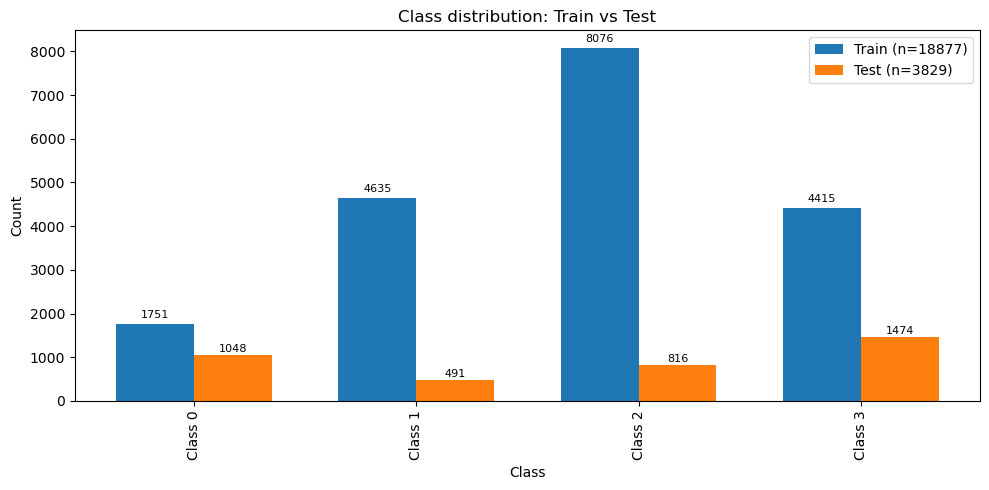

In [ ]:
# Fonction faite par IA qui permet d'observer la composition du dataset

import pandas as pd

def plot_class_distribution(train_dataset=None, test_dataset=None, train_y=None, test_y=None, num_classes=None, class_names=None):
    """
    Show repartition of ground-truth classes between training and test sets.
    Accepts either Dataset objects (with get_data_arrays) or raw label arrays.
    If labels are one-hot, they will be converted with argmax.
    """
    def _to_label_array(y):
        if y is None:
            return None
        arr = np.array(y)
        # one-hot -> argmax
        if arr.ndim == 2:
            return arr.argmax(axis=1)
        # try to convert enums/objects to ints
        def _elem_to_int(v):
            if hasattr(v, "value"):
                return int(v.value)
            try:
                return int(v)
            except Exception:
                return v
        converted = np.array([_elem_to_int(v) for v in arr])
        return converted.astype(int)

    # extract from Dataset objects if provided
    if train_dataset is not None:
        _, train_y = train_dataset.get_data_arrays()
    if test_dataset is not None:
        _, test_y = test_dataset.get_data_arrays()

    train_y = _to_label_array(train_y)
    test_y  = _to_label_array(test_y)

    if train_y is None and test_y is None:
        raise ValueError("Provide at least train_dataset/train_y or test_dataset/test_y")

    # determine number of classes
    max_label = -1
    for arr in (train_y, test_y):
        if arr is not None and len(arr) > 0:
            max_label = max(max_label, int(np.max(arr)))
    if num_classes is None:
        if max_label >= 0:
            num_classes = max_label + 1
        elif 'num_classes' in globals():
            num_classes = globals()['num_classes']
        elif 'clf' in globals() and hasattr(globals()['clf'], 'n_classes'):
            num_classes = globals()['clf'].n_classes
        else:
            raise ValueError("Cannot infer num_classes; pass num_classes argument")

    train_counts = np.zeros(num_classes, dtype=int)
    test_counts  = np.zeros(num_classes, dtype=int)
    if train_y is not None:
        vals, cnts = np.unique(train_y, return_counts=True)
        for v, c in zip(vals, cnts):
            if 0 <= int(v) < num_classes:
                train_counts[int(v)] = c
    if test_y is not None:
        vals, cnts = np.unique(test_y, return_counts=True)
        for v, c in zip(vals, cnts):
            if 0 <= int(v) < num_classes:
                test_counts[int(v)] = c

    total_train = train_counts.sum()
    total_test  = test_counts.sum()
    train_pct = (train_counts / total_train * 100) if total_train > 0 else np.zeros_like(train_counts, dtype=float)
    test_pct  = (test_counts  / total_test  * 100) if total_test  > 0 else np.zeros_like(test_counts, dtype=float)

    # class labels
    if class_names is None:
        class_names = [f"Class {i}" for i in range(num_classes)]
    else:
        if len(class_names) < num_classes:
            # pad
            class_names = list(class_names) + [f"Class {i}" for i in range(len(class_names), num_classes)]

    # build summary table and print
    df = pd.DataFrame({
        "class_index": range(num_classes),
        "class_name": class_names[:num_classes],
        "train_count": train_counts,
        "test_count": test_counts,
        "train_pct": np.round(train_pct, 2),
        "test_pct": np.round(test_pct, 2)
    })
    print(df)

    # plot side-by-side bar chart (counts)
    x = np.arange(num_classes)
    width = 0.35
    plt.figure(figsize=(max(10, num_classes * 0.4), 5))
    plt.bar(x - width/2, train_counts, width, label=f"Train (n={total_train})")
    plt.bar(x + width/2, test_counts, width, label=f"Test (n={total_test})")
    plt.xticks(x, class_names[:num_classes], rotation=90)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Class distribution: Train vs Test")
    plt.legend()
    # annotate counts
    for i in x:
        plt.text(i - width/2, train_counts[i] + max(1, total_train * 0.005), str(train_counts[i]), ha='center', va='bottom', fontsize=8)
        plt.text(i + width/2, test_counts[i]  + max(1, total_test  * 0.005),  str(test_counts[i]),  ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

# Example usage in this notebook:
plot_class_distribution(train_dataset=train_dataset, test_dataset=test_dataset)

In [ ]:
# Exemple avec 2 vidéos pour tester
video1 = VideoData(filename="data/test_other.mp4", ground_truth=Exercise.SQUAT)
video1.landmark_estimation()
video1.normalize()

dataset = Dataset()
dataset.add_video_data(video1)


🔍 Processing video frames...


Reading frames: 100%|█████████████████████████| 368/368 [00:43<00:00,  8.51it/s]


✅ Interpolation done.
💾 Landmarks saved to interpolated_landmarks.txt


In [ ]:
for frame_data in dataset.datas:
    clf.predict_frame(frame_data)
    print(f"Vidéo: {frame_data.filename}, Frame: {frame_data.frame_index}, Prédit: {frame_data.predicted_class}, Vérité: {frame_data.ground_truth}")

Vidéo: data/test_other.mp4, Frame: 0, Prédit: Exercise.PULL_UP, Vérité: Exercise.SQUAT
Vidéo: data/test_other.mp4, Frame: 1, Prédit: Exercise.PULL_UP, Vérité: Exercise.SQUAT
Vidéo: data/test_other.mp4, Frame: 2, Prédit: Exercise.PULL_UP, Vérité: Exercise.SQUAT
Vidéo: data/test_other.mp4, Frame: 3, Prédit: Exercise.PULL_UP, Vérité: Exercise.SQUAT
Vidéo: data/test_other.mp4, Frame: 4, Prédit: Exercise.PULL_UP, Vérité: Exercise.SQUAT
Vidéo: data/test_other.mp4, Frame: 5, Prédit: Exercise.PULL_UP, Vérité: Exercise.SQUAT
Vidéo: data/test_other.mp4, Frame: 6, Prédit: Exercise.PULL_UP, Vérité: Exercise.SQUAT
Vidéo: data/test_other.mp4, Frame: 7, Prédit: Exercise.PULL_UP, Vérité: Exercise.SQUAT
Vidéo: data/test_other.mp4, Frame: 8, Prédit: Exercise.PULL_UP, Vérité: Exercise.SQUAT
Vidéo: data/test_other.mp4, Frame: 9, Prédit: Exercise.PULL_UP, Vérité: Exercise.SQUAT
Vidéo: data/test_other.mp4, Frame: 10, Prédit: Exercise.PULL_UP, Vérité: Exercise.SQUAT
Vidéo: data/test_other.mp4, Frame: 11, Pré